In [1]:
import torch
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import random
import sys
import pickle
sys.path.append("..")
from inference import GaussMarkovLagrange
from likelihoods import PointProcess
from mappings import AffineMapping
from transition import FixedPointSparseGP, SparseGP
from kernels import RBF
from linkfunctions import Exp
from models import PointProcessGPSDEmodel, GPSDE

In [2]:
print(torch.__version__) # double check that this is the version from requirements.txt

1.10.0+cpu


### Data

In [3]:
def plotRaster(event_times_list, **kwargs):
    """ function to plot raster plot for a given trial"""
    ax = plt.gca()
    for ith, trial in enumerate(event_times_list):
        plt.vlines(trial, ith + .5, ith + 1.5, **kwargs)
    plt.ylim(.5, len(event_times_list) + .5)
    return ax

In [6]:
data = np.load('../Data/Cellline1_Date190328_Chip2135.npz', allow_pickle=True)

In [7]:
yDim = 40 #nmb neurons
nTrials = 3
tmax = 30
trLen = tmax * np.ones(nTrials)
times, ids = data['times'], data['ids']
ids_set, counts = np.unique(ids, return_counts=True)
valid_ids_set = ids_set[np.argsort(counts)[::-1][:yDim]] #choice of neurons

times = times[np.isin(ids, valid_ids_set)]
ids = ids[np.isin(ids, valid_ids_set)]

Yspike = []

for i in range(nTrials): #every trial is 30s in the time serie (a bit of explanation on this )
    Ytrial = []
    valid_spk_idx = np.logical_and(times > i*tmax, times < (i+1)*tmax)
    valid_times = times[valid_spk_idx] - i*tmax
    valid_ids = ids[valid_spk_idx]
    for neuron_id in valid_ids_set:
        Ytrial.append(valid_times[valid_ids == neuron_id])
    Yspike.append(Ytrial)

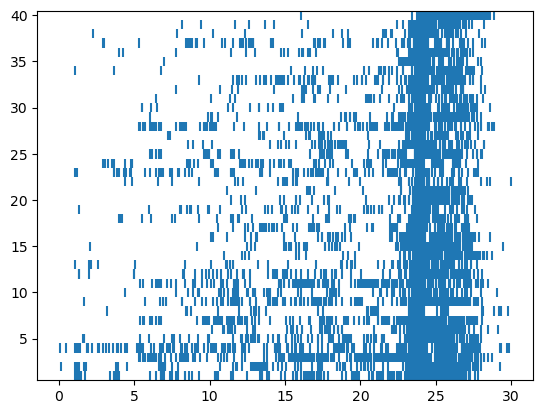

In [8]:
np.random.seed(101)
torch.manual_seed(22) #mu ini

xDim = 2
trLen = tmax * np.ones(nTrials) # trial length
C = 2.*np.random.rand(xDim,yDim) * np.random.choice([-1,1],size=(xDim,yDim))
d = 0.1*np.random.randn(1,yDim)

plotRaster(Yspike[1])
plt.show()

### Model

In [9]:
dtgrid = 0.01 # discretisation for solving ODEs
xDim = 2 # two latents

# pick model components:
link = Exp() # exponential link function
like = PointProcess(Yspike, link, trLen, dtstep=dtgrid, nLeg=100) # point process likelihood
outputMapping = AffineMapping(torch.tensor(C), torch.tensor(d)) # affine output mapping
kern = RBF(xDim, lengthscales_Init=.5 * torch.ones((xDim, 1))) # RBF kernel
#kern.lengthscales.requires_grad = False # fix kernel lengthscales

# generater inducing point locations on a 2D grid
xmin, xmax = -2., 2.
numZ = 5
Zs1, Zs2 = torch.meshgrid([torch.linspace(xmin,xmax,numZ), torch.linspace(xmin,xmax,numZ)])

Zs = torch.cat((Zs1.reshape(-1,1),Zs2.reshape(-1,1)),dim=1)

transfunc = SparseGP(kern, Zs, useClosedForm=False) # choose sparse GP as a transition function
transfunc.q_mu.data = torch.randn(transfunc.q_mu.size()).type(torch.float64) # random initialisation for inducing point posterior mean

# uncomment to instead condition on fixed points
#Zs_fx = torch.tensor([0., 0.]).view(-1,xDim)
# transition function conditioned on fixed point
#transfunc = SparseGP(kern, Zs, Zs_fx) 


# build point procces generative model for continuous time spike-time observations
model = PointProcessGPSDEmodel(xDim, transfunc, outputMapping, like, nLeg=100)

# assemble inference algorithm
lr=0.1 #learning rate
inference = GaussMarkovLagrange(xDim, trLen, learningRate=lr, dtstep=dtgrid)

# create GPSDE model object 
myGPSDE = GPSDE(model, inference)

# fix inducing points on chosen grid
myGPSDE.model.transfunc.Zs.requires_grad = False


d:\logiciel\miniconda\lib\site-packages\torch\functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ..\aten\src\ATen\native\TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


### Run and save

In [ ]:
# run EM (increase number of iterations for better results)
myGPSDE.variationalEM(niter=100,eStepIter=2, mStepIter=2)
#myGPSDE.variationalEM(niter=30,eStepIter=1, mStepIter=2)

In [ ]:
#Save the results
name="20_80_221724_20_6iter_allneuron800_dt0.05"
torch.save(myGPSDE.model,'Graph_and_modelsave/GPSDE_model_'+name+'.pt')
with open("Graph_and_modelsave/GPSDE_inference_"+name+".pkl",'wb') as file:
    pickle.dump(myGPSDE.inference,file)

with open("Graph_and_modelsave/GPSDE_"+name+".pkl",'wb') as file:
    pickle.dump(myGPSDE,file)

### Load

In [ ]:
model=torch.load('Graph_and_modelsave/GPSDE_model_'+name+'.pt')
with open("Graph_and_modelsave/GPSDE_inference_"+name+".pkl",'rb') as file:
    inference=pickle.load(file)

### Plots

In [ ]:
# evaluate trial
idx = 0
testTimes = torch.linspace(0,trLen[idx],int(trLen[idx]/0.001))

m, S = myGPSDE.inference.predict_marginals(idx, testTimes)
mr, Sr, Corth = myGPSDE.model.outputMapping.orthogonaliseLatents(m,S)


# plot the latent path and data in orthogonalised subspace
f, ax = plt.subplots()
f.set_figheight(7.5)
f.set_figwidth(15)
for i in range(xDim):
#     ax.plot(testTimes.numpy(),xpath[idx],color='black',linewidth=0.5,label='x(t)')
    ax.plot(testTimes.numpy(),mr[:,0,i].detach().squeeze().numpy(), label='$m_x(t)$')
    ax.fill_between(testTimes.numpy(), mr[:,0,i].detach().numpy()+np.sqrt(Sr[:,i,i].detach().numpy()), 
                mr[:,0,i].detach().squeeze().numpy()-np.sqrt(Sr[:,i,i].detach().numpy()), alpha=0.2)

    
#Latents = Corth.detach().numpy().T @ (np.stack(logRate[idx] - d).T) # data projected into same subspace as inferred latents
#plt.plot(np.linspace(0,trLen[idx],int(trLen[idx]/0.001)),Latents[0,:],color='black')
#plt.plot(np.linspace(0,trLen[idx],int(trLen[idx]/0.001)),Latents[1,:],color='black')

# plot where observatioins lie
ax.locator_params(nbins=4)
ax.set_ylabel('$x(t)$',fontsize=26)
ax.set_xlabel('$t$',fontsize=26)
ax.set_title('latent process',fontsize=26)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.savefig('Graph_and_modelsave/Latent_graph_'+name+'.pdf')
plt.show()

In [ ]:
# visualise learned transition function and true transition function
ngrid = 20
xmin = -4.5
xmax = 4.5
x = torch.linspace(xmin,xmax,ngrid)
y = torch.linspace(xmin,xmax,ngrid)

xv, yv = torch.meshgrid([x, y])
xygrid = torch.cat((yv.reshape(-1, 1),xv.reshape(-1, 1)),dim=1)
out_est = myGPSDE.model.transfunc.predict(xygrid.unsqueeze(0))
#out_true = func(np.concatenate((yv.numpy().reshape(-1, 1),xv.numpy().reshape(-1, 1)),axis=1))


In [ ]:

# visualise dynamics
sz = 6
plt.figure(figsize=(sz,sz))

plt.streamplot(x.numpy(), y.numpy(), out_est[0,:,0].detach().reshape(ngrid,ngrid).numpy(), 
           out_est[0,:,1].detach().numpy().reshape(ngrid, ngrid), arrowsize=1.2, 
                  density=2, color='mediumslateblue')
#plt.plot(mr[:,0,0].detach().squeeze().numpy(), mr[:,0,1].detach().squeeze().numpy())

plt.plot(myGPSDE.model.transfunc.Zs.detach().numpy()[:,0,], myGPSDE.model.transfunc.Zs.detach().numpy()[:,1], 'o', color='black', markersize=5)
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.title('estimated dynamics')
plt.axis('square')
#plt.locator_params(nbins=3)
plt.savefig('Graph_and_modelsave/dynamics_'+name+'.pdf')
plt.show()

In [ ]:
myGPSDE.model.transfunc.Zs